In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import joblib

# EDA

In [3]:
#Read the dataset
df = pd.read_csv('df.csv')

In [4]:
# Display basic information about the df set
print("Basic Information:")
print(df .info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226486 entries, 0 to 226485
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      226486 non-null  int64  
 1   date            226486 non-null  object 
 2   category_id     226486 non-null  int64  
 3   sku_id          226486 non-null  int64  
 4   sales_price     226486 non-null  float64
 5   sales_quantity  226486 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.4+ MB
None


In [5]:
# Display the first few rows of the dataset
print("\nFirst few rows:")
print(df.head())


First few rows:
   Unnamed: 0        date  category_id  sku_id  sales_price  sales_quantity
0       78161  2016-11-25            7    1108       457.60             1.0
1       81079  2016-11-18            7    2999       470.60             1.0
2       81177  2016-11-18            7    1428       717.60             1.0
3       81292  2016-11-18            7    3923       383.50             1.0
4       81416  2016-11-18           17    8075        18.85             2.0


In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Unnamed: 0        0
date              0
category_id       0
sku_id            0
sales_price       0
sales_quantity    0
dtype: int64


* Remove the Unnamed: 0 column because it is not needed.

In [7]:
#Deleting column 'Unnamed' - this data is not nessesary
df = df.drop(columns=['Unnamed: 0'])

df

,date,category_id,sku_id,sales_price,sales_quantity
0,2016-11-25,7,1108,457.60,1.0
1,2016-11-18,7,2999,470.60,1.0
2,2016-11-18,7,1428,717.60,1.0
3,2016-11-18,7,3923,383.50,1.0
4,2016-11-18,17,8075,18.85,2.0
...,...,...,...,...,...
226481,2020-10-14,7,21442,570.70,1.0
226482,2020-10-14,7,502340,505.70,3.0
226483,2020-10-14,7,723588,401.70,3.0
226484,2020-10-17,7,792124,778.70,1.0


In [8]:
df.describe()
#we don't have negative values in sales_price and sales_quantity columns

,category_id,sku_id,sales_price,sales_quantity
count,226486.000000,226486.000000,226486.000000,226486.000000
mean,15.069594,497813.898607,109.033102,16.078857
std,4.625731,242446.818578,151.500911,184.248121
min,7.000000,1045.000000,1.027000,1.000000
25%,17.000000,398064.000000,38.220000,1.000000
50%,17.000000,550996.000000,51.350000,3.000000
75%,17.000000,702116.000000,71.500000,5.000000
max,23.000000,838924.000000,2923.700000,8069.000000


In [9]:
#check if the category_id is balanced
category_id_counts = df['category_id'].value_counts()
category_id_counts

category_id
17    160797
7      51959
23     13730
Name: count, dtype: int64

* Let's convert the date column to a date format.

In [10]:
#Transforming column 'date' on datetime format
df['date'] = pd.to_datetime(df['date'])
#checking output after converting
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226486 entries, 0 to 226485
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            226486 non-null  datetime64[ns]
 1   category_id     226486 non-null  int64         
 2   sku_id          226486 non-null  int64         
 3   sales_price     226486 non-null  float64       
 4   sales_quantity  226486 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 8.6 MB


(None,
         date  category_id  sku_id  sales_price  sales_quantity
 0 2016-11-25            7    1108       457.60             1.0
 1 2016-11-18            7    2999       470.60             1.0
 2 2016-11-18            7    1428       717.60             1.0
 3 2016-11-18            7    3923       383.50             1.0
 4 2016-11-18           17    8075        18.85             2.0)

### Let's do some deeper analysis:
* Distribution of sales by day 
* Distribution of sales by category 
* Distribution of sales by product. We will use SKU
* Analysis of price median

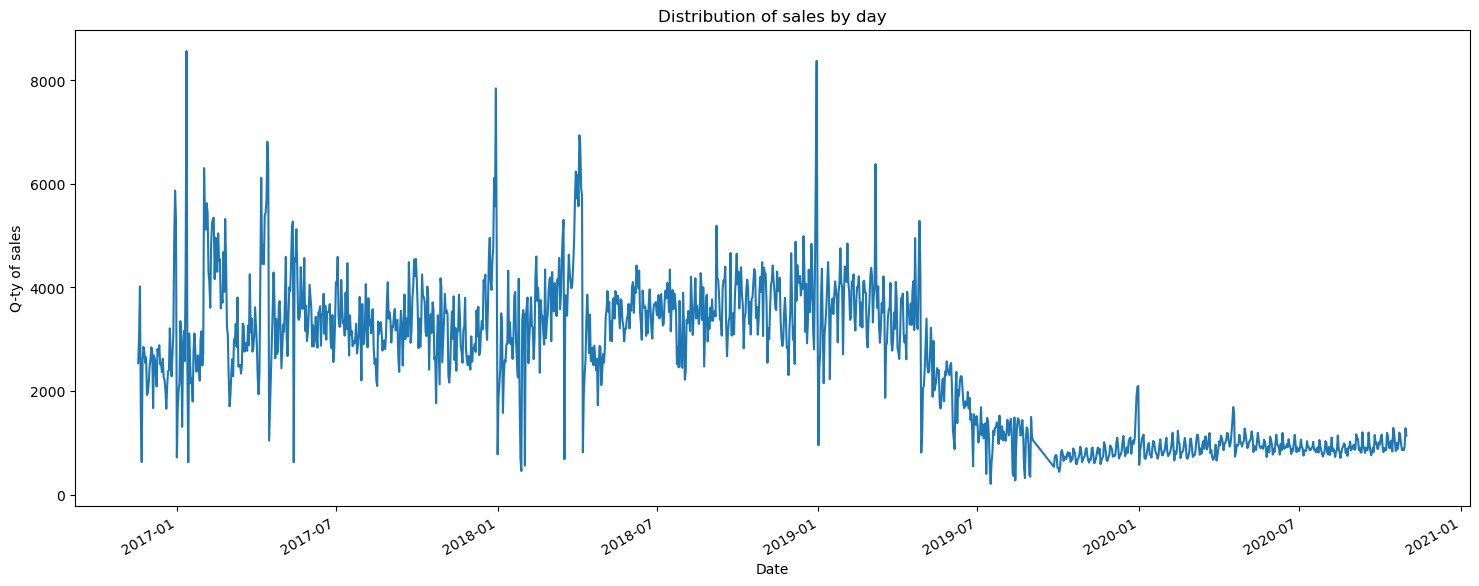

In [11]:
#Distribution of sales by day
plt.figure(figsize=(18, 7))
df.groupby('date')['sales_quantity'].sum().plot(title='Distribution of sales by day')
plt.xlabel('Date')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by day: Visualization shows that the number of sales has a significant variability, which may be due to seasonality or other factors. Also , we have a significant drop in sales_quantity

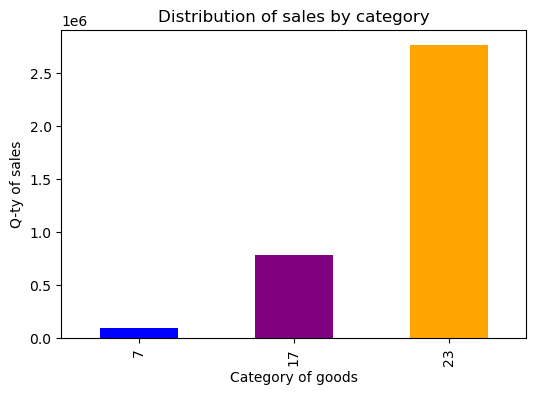

In [12]:
#Distribution of sales by category 
plt.figure(figsize=(6, 4))
colors = ['blue', 'purple', 'orange']
df.groupby('category_id')['sales_quantity'].sum().plot(kind='bar', color=colors, title='Distribution of sales by category')
plt.xlabel('Category of goods')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by category: Visualization shows that the category "23" has a significant q-ty compared to "7" and "17"

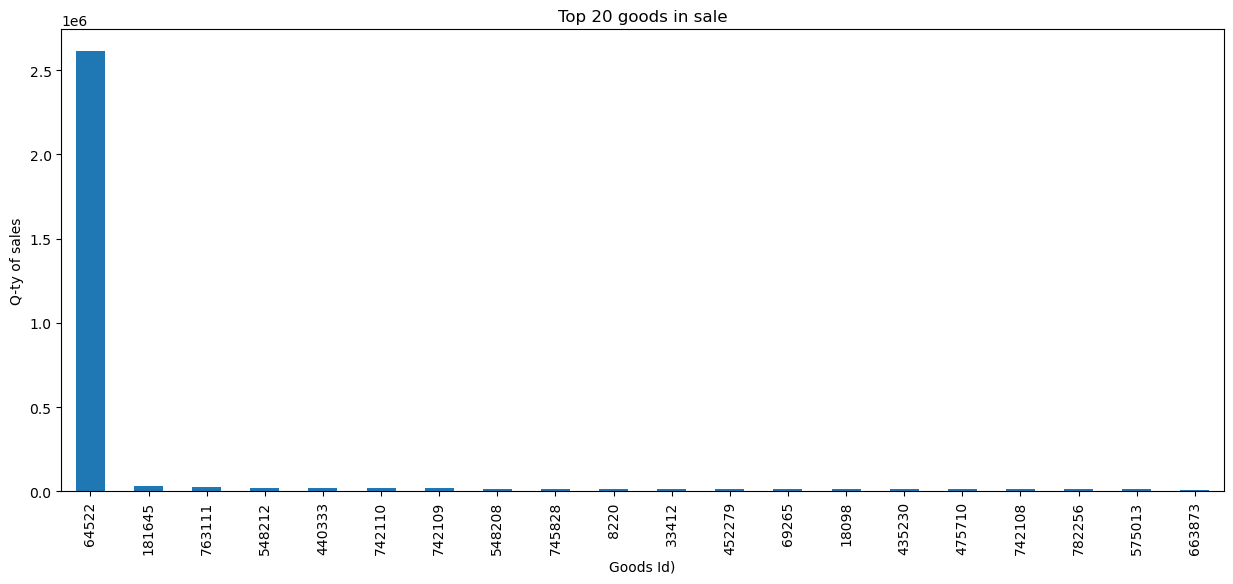

In [13]:
# Distribution of sales by product. We will use SKU.
plt.figure(figsize=(15, 6))
top_sku_sales = df.groupby('sku_id')['sales_quantity'].sum().sort_values(ascending=False).head(20)
top_sku_sales.plot(kind='bar', title='Top 20 goods in sale')
plt.xlabel('Goods Id)')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by product: SKUs_id 64522 has the highest q-ty of sales

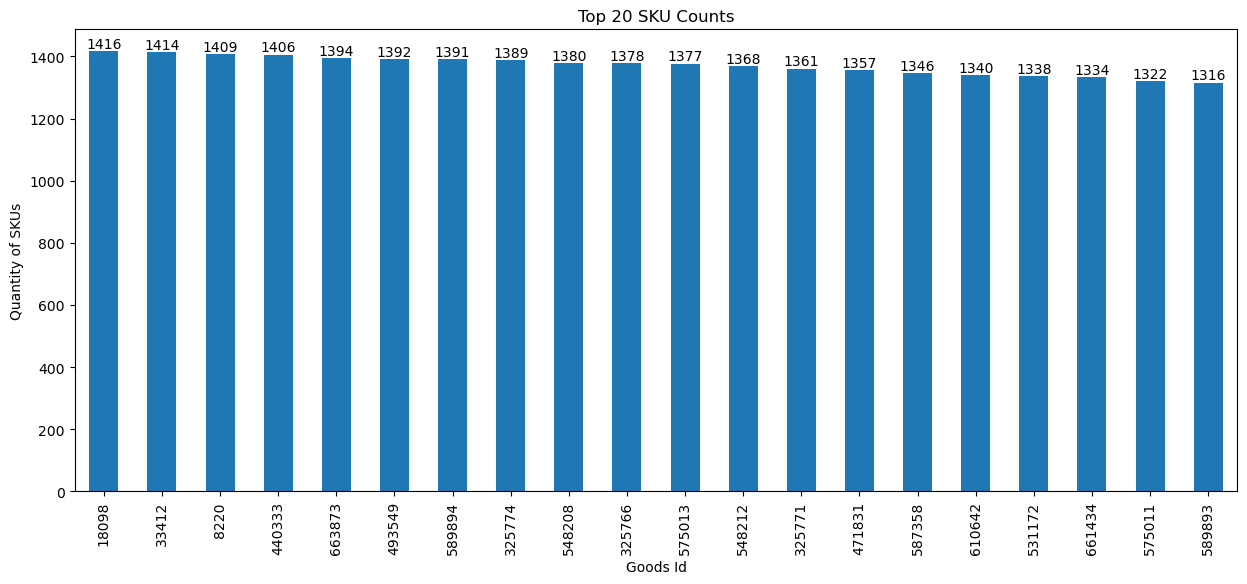

In [14]:
# Count the occurrences of each SKU
sku_counts = df['sku_id'].value_counts().head(20)

# Plotting the top 20 SKU counts
plt.figure(figsize=(15, 6))
ax = sku_counts.plot(kind='bar', title='Top 20 SKU Counts')
plt.xlabel('Goods Id')
plt.ylabel('Quantity of SKUs')

# Annotating each bar with the quantity value
for i in ax.containers:
    ax.bar_label(i)

# Display the plot
plt.show()

# Comments

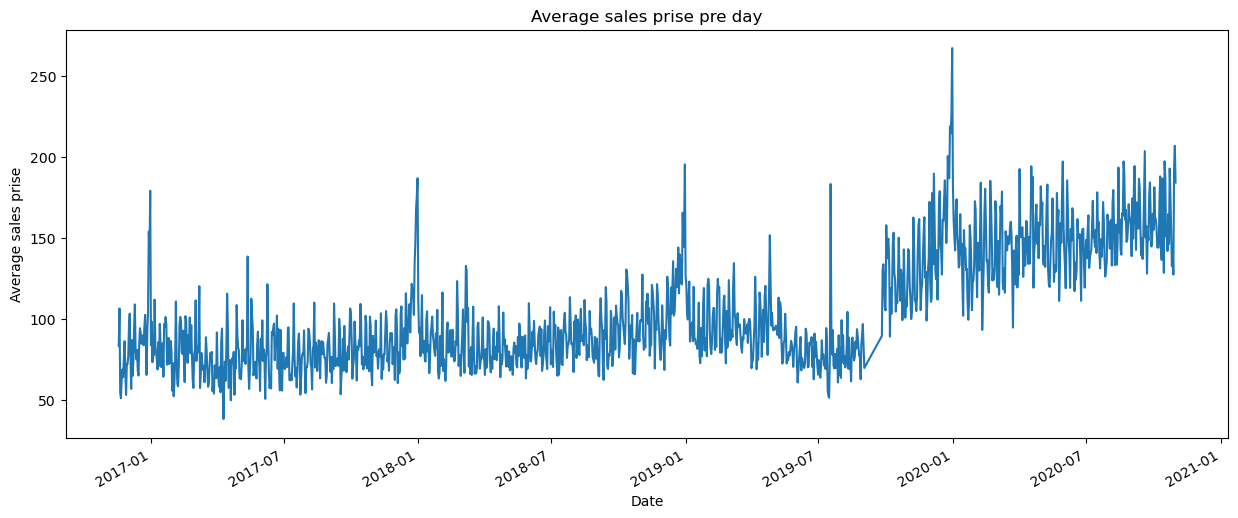

In [15]:
#Analysis of price median
plt.figure(figsize=(15, 6))
df.groupby('date')['sales_price'].mean().plot(title='Average sales prise pre day')
plt.xlabel('Date')
plt.ylabel('Average sales prise')
plt.show()

* Average sale price per day: We can notice some growing of sales from 01-2020

#### Look like after the growing in sales price from 01-2020 we have a significant sales drop in q-ty

# Feature engineering

In [16]:
#Create day indicators for week, month, year, day and day off
df['day_of_week'] = df['date'].dt.dayofweek
#Days Indicator (0 - weekday, 1 - day off)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year

In [17]:
#Sort df by 'date'
df = df.sort_values(by='date')

#check
df.head()

,date,category_id,sku_id,sales_price,sales_quantity,day_of_week,is_weekend,day_of_month,month,week_of_year,year
2355,2016-11-18,17,415510,23.205,1.0,4,0,18,11,46,2016
2356,2016-11-18,17,420009,22.490,2.0,4,0,18,11,46,2016
8144,2016-11-18,17,567734,23.205,1.0,4,0,18,11,46,2016
8023,2016-11-18,17,556333,32.760,2.0,4,0,18,11,46,2016
7797,2016-11-18,7,566241,283.400,1.0,4,0,18,11,46,2016


# Modeling the data

In [18]:
#Encoding the data using the On-Hot Encoding for categorical variables
categorical_features = ['category_id', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'week_of_year', 'year']

encoder = OneHotEncoder(sparse_output=False)#sparse=False, output data in the form of a normal dense NumPy array
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
df_encoded = df_encoded.drop(columns=categorical_features)

In [19]:
df_encoded.head()

,date,sku_id,sales_price,sales_quantity,category_id_7,category_id_17,category_id_23,day_of_week_0,day_of_week_1,day_of_week_2,...,week_of_year_48.0,week_of_year_49.0,week_of_year_50.0,week_of_year_51.0,week_of_year_52.0,year_2016,year_2017,year_2018,year_2019,year_2020
0,2016-11-18,415510,23.205,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2016-11-18,420009,22.490,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016-11-18,567734,23.205,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2016-11-18,556333,32.760,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2016-11-18,566241,283.400,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
# Separate numerical features
scaler = StandardScaler()
numerical_features = df_encoded[['sales_price']]
numerical_features_scaled = scaler.fit_transform(numerical_features)

In [21]:
# Combine scaled numerical features with encoded categorical features
df_encoded_scaled = pd.concat([df_encoded.reset_index(drop=True).drop(columns=['sales_price']), 
                               pd.DataFrame(numerical_features_scaled, columns=['sales_price'])], axis=1)

In [22]:
# Features and target variable
X = df_encoded_scaled.drop(columns=['sales_quantity', 'date'])
y = df_encoded['sales_quantity']

In [23]:
# Define the split index for 80% train and 20% test
split_index = int(len(df) * 0.8)

# Split the data
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [24]:
#Set up k-cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

In [25]:
#Creating pipeline for each of the model
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
]

In [26]:
# Define scorers
scorers = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))),
    'r2': make_scorer(r2_score)
}

In [27]:
# Evaluating using k-cross validation
for name, model in models:
    results = {}
    for scorer_name, scorer in scorers.items():
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer, n_jobs=-1)  # використано n_jobs=-1 для паралельної обробки
        results[scorer_name] = scores.mean()
    
    print(f"{name}: {results}")

Linear Regression: {'mae': 40.94313488957486, 'mse': 38512.75854392624, 'rmse': 196.2130234013318, 'r2': 0.09102424565854775}
Random Forest: {'mae': 4.586505624631587, 'mse': 2601.3751144752287, 'rmse': 50.91043274170248, 'r2': 0.9385500935139071}


In [28]:
# Feature importance for Random Forest
if name == 'Random Forest':
    model.fit(X_train, y_train)  # тренування моделі на повному тренувальному наборі
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df_rf = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df_rf = feature_importance_df_rf.sort_values(by='importance', ascending=False).head(5)  # вибір топ-5 ознак
    print(f"Feature importance for {name}:")
    print(feature_importance_df_rf)

Feature importance for Random Forest:
         feature  importance
113  sales_price    0.899878
111    year_2019    0.014703
47       month_4    0.006741
46       month_3    0.004794
108    year_2016    0.003549


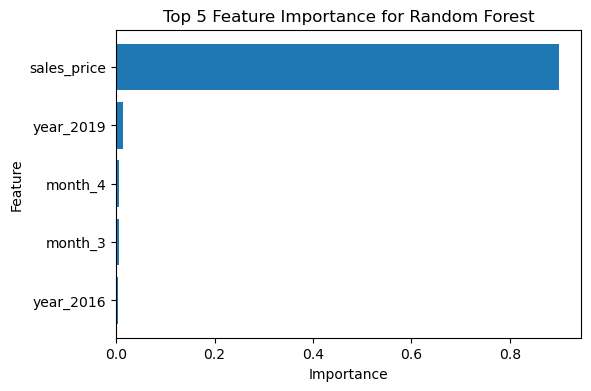

In [29]:
# Plotting top 5 feature importance
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df_rf['feature'], feature_importance_df_rf['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

build new ML model based on feature selection

In [30]:
#save first 100 rows
#df_first_100_rows = df_encoded_scaled.head(100)

#Save data to CSV
#df_first_100_rows.to_csv('first_100_rows.csv', index=False)

In [31]:
# Features and target variable based on Feature selection
# Drop the specified columns
columns_to_drop = ['sales_quantity', 'date'] + \
                  [col for col in df_encoded_scaled.columns if 'day_of_week' in col] + \
                  [col for col in df_encoded_scaled.columns if 'week_of_year' in col] + \
                  [col for col in df_encoded_scaled.columns if 'day_of_month' in col]

df_selected = df_encoded_scaled.drop(columns=columns_to_drop)

In [32]:
df_selected.head()

,sku_id,category_id_7,category_id_17,category_id_23,is_weekend_0,is_weekend_1,month_1,month_2,month_3,month_4,...,month_9,month_10,month_11,month_12,year_2016,year_2017,year_2018,year_2019,year_2020,sales_price
0,415510,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.566520
1,420009,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.571239
2,567734,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.566520
3,556333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.503451
4,566241,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.150932


In [33]:
# Select the features
X_selected = df_selected
y = df_encoded_scaled['sales_quantity']

In [34]:
# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [35]:
# Split the data using the last fold for test
for train_index, test_index in tscv.split(X_selected):
    X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [36]:
# Train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
# Predict on the test set
y_pred = model.predict(X_test)

In [38]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")

Test MAE: 2.4571973450151363
Test MSE: 26.127275243094513
Test RMSE: 5.111484641774297
Test R2: 0.638513179295416


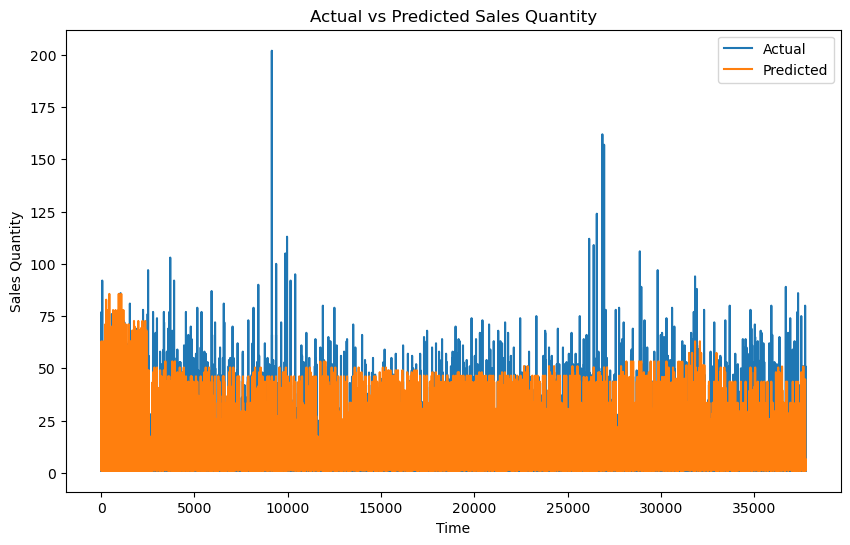

In [39]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sales Quantity')
plt.title('Actual vs Predicted Sales Quantity')
plt.legend()
plt.show()

In [40]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [41]:
# Set up RandomizedSearchCV
random_grid_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)


In [42]:
# Fit RandomizedSearchCV
random_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_squared_error', verbose=2)

In [43]:
# Best hyperparameters
best_params = random_grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}


In [44]:
# Train the Random Forest model with best hyperparameters
best_model = random_grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=300, random_state=42)

In [45]:
# Predict on the test set with best model
y_pred_best = best_model.predict(X_test)

In [46]:
# Calculate metrics for best model
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Best Model Test MAE:", mae_best)
print("Best Model Test MSE:", mse_best)
print("Best Model Test RMSE:", rmse_best)
print("Best Model Test R2:", r2_best)

Best Model Test MAE: 2.7122141033186478
Best Model Test MSE: 27.653433710220966
Best Model Test RMSE: 5.258653222092227
Best Model Test R2: 0.6173978441890988


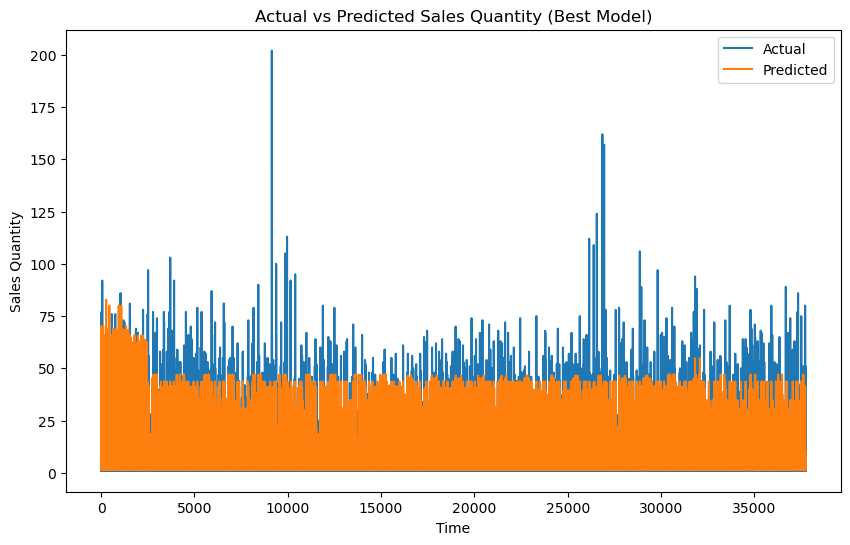

In [47]:
# Plotting the results for the best model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_best, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sales Quantity')
plt.title('Actual vs Predicted Sales Quantity (Best Model)')
plt.legend()
plt.show()

### Otput
* Conventional RandomForest has significantly worse error rates (MAE, MSE, RMSE) than models with feature selection and hyperparameter tuning, but very high R2.
* RandomForest with Feature Selection shows the best results in terms of MAE, MSE, and RMSE, indicating more accurate predictions. R2 is slightly lower but still acceptable.
* RandomForest with Feature Selection and Hyperparameter Tuning performs slightly worse than the model without tuning, which may indicate possible overtraining or not good enough hyperparameter selection.

* For further work, I think it is better to choose RandomForest with Feature Selection (model 2), because it shows the best results in terms of forecast accuracy (lowest MAE, MSE and RMSE). The model with hyperparameter tuning (model 3) shows worse results, which may indicate the need for further refinement of the tuning process.

In [48]:
#RandomForest with Feature Selection
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [49]:
#Saving feature selection
feature_names = list(X_train.columns)

In [54]:
#Saving model and feature selection
import joblib
joblib.dump(model, 'random_forest_feature_selection_model.pkl', compress=7)
joblib.dump(feature_names, 'feature_names.pkl')

['feature_names.pkl']